In [1]:
# Packages
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

print('Packages imported successfully!')

Packages imported successfully!


In [2]:
# Data Import
data = sns.load_dataset('flights')
print(f'Number of Entries: {len(data)}')
data.head()

Number of Entries: 144


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
# Convert passenger data to float32
num_points = len(data)
Xy = data.passengers.values.astype(np.float32)
print(f'Data shape: {Xy.shape}')
print(f'Data range: {Xy.min()} to {Xy.max()}')

Data shape: (144,)
Data range: 104.0 to 622.0


In [4]:
# Scale the data
scaler = MinMaxScaler()
Xy_scaled = scaler.fit_transform(Xy.reshape(-1, 1))
print(f'Scaled data shape: {Xy_scaled.shape}')
print(f'Scaled data range: {Xy_scaled.min():.4f} to {Xy_scaled.max():.4f}')

Scaled data shape: (144, 1)
Scaled data range: 0.0000 to 1.0000


## Data Preparation

In [5]:
# Simple approach for time series
sequence_length = 6  # Look back 6 months

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len].flatten())
        y.append(data[i+seq_len].item())
    return np.array(X), np.array(y)

# Simple train/test split
train_size = 120
train_data = Xy_scaled[:train_size]
test_data = Xy_scaled[train_size:]

print(f'Train data: {len(train_data)} points')
print(f'Test data: {len(test_data)} points')

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Convert to tensors
X_train = torch.FloatTensor(X_train).reshape(-1, sequence_length, 1)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_test = torch.FloatTensor(X_test).reshape(-1, sequence_length, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

print(f'Final tensor shapes:')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

Train data: 120 points
Test data: 24 points
X_train shape: (114, 6), y_train shape: (114,)
X_test shape: (18, 6), y_test shape: (18,)
Final tensor shapes:
X_train: torch.Size([114, 6, 1]), y_train: torch.Size([114, 1])
X_test: torch.Size([18, 6, 1]), y_test: torch.Size([18, 1])


## Simple Model

In [6]:
class SimpleFlightsModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(SimpleFlightsModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Single LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Simple output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

# Initialize model
model = SimpleFlightsModel(input_size=1, hidden_size=32, output_size=1)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model parameters: {total_params}')
print(model)

Model parameters: 4513
SimpleFlightsModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
# Setup training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Test forward pass
with torch.no_grad():
    test_output = model(X_train[:5])
    print(f'Test output shape: {test_output.shape}')
    print(f'Test output range: [{test_output.min():.4f}, {test_output.max():.4f}]')

Test output shape: torch.Size([5, 1])
Test output range: [-0.1977, -0.1973]


## Training

Training for 1000 epochs...
Epoch  100: Train MSE: 0.005031, Test MSE: 0.020943
Epoch  200: Train MSE: 0.002781, Test MSE: 0.010259
Epoch  300: Train MSE: 0.002349, Test MSE: 0.008749
Epoch  400: Train MSE: 0.002137, Test MSE: 0.008303
Epoch  500: Train MSE: 0.001589, Test MSE: 0.006438
Epoch  600: Train MSE: 0.001217, Test MSE: 0.007145
Epoch  700: Train MSE: 0.001077, Test MSE: 0.007876
Epoch  800: Train MSE: 0.000971, Test MSE: 0.008176
Epoch  900: Train MSE: 0.000963, Test MSE: 0.006878
Epoch 1000: Train MSE: 0.000591, Test MSE: 0.012242
Training completed!


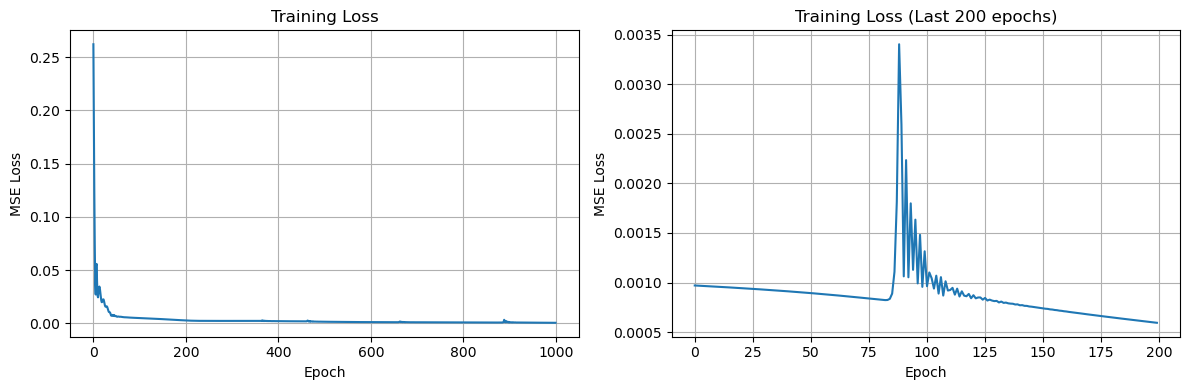

In [8]:
# Simple training loop
num_epochs = 1000
print_every = 100
losses = []

print(f'Training for {num_epochs} epochs...')

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    losses.append(loss.item())
    
    # Print progress
    if (epoch + 1) % print_every == 0:
        with torch.no_grad():
            model.eval()
            train_pred = model(X_train)
            train_mse = criterion(train_pred, y_train).item()
            
            test_pred = model(X_test)
            test_mse = criterion(test_pred, y_test).item()
            
            print(f'Epoch {epoch+1:4d}: Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}')

print('Training completed!')

# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses[-200:])
plt.title('Training Loss (Last 200 epochs)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation

=== TEST SET PERFORMANCE ===
MSE: 3284.82
RMSE: 57.31
MAE: 43.88
R²: 0.4137


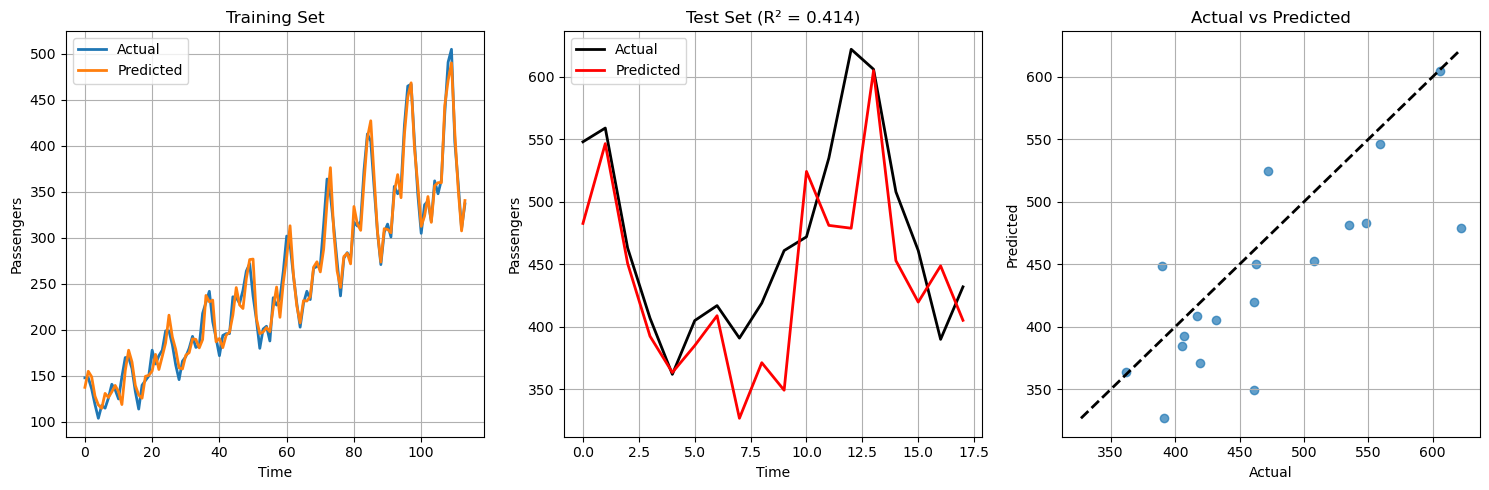


=== SAMPLE PREDICTIONS ===
Sample 1: Actual=548.0, Predicted=482.7, Error=65.3
Sample 2: Actual=559.0, Predicted=546.5, Error=12.5
Sample 3: Actual=463.0, Predicted=450.6, Error=12.4
Sample 4: Actual=407.0, Predicted=392.5, Error=14.5
Sample 5: Actual=362.0, Predicted=363.5, Error=1.5


In [9]:
# Evaluation
model.eval()

with torch.no_grad():
    train_pred = model(X_train).numpy()
    test_pred = model(X_test).numpy()
    train_actual = y_train.numpy()
    test_actual = y_test.numpy()

# Convert back to original scale
train_pred_orig = scaler.inverse_transform(train_pred)
train_actual_orig = scaler.inverse_transform(train_actual)
test_pred_orig = scaler.inverse_transform(test_pred)
test_actual_orig = scaler.inverse_transform(test_actual)

# Calculate metrics
mse = np.mean((test_actual_orig - test_pred_orig)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_actual_orig - test_pred_orig))

# R-squared
ss_res = np.sum((test_actual_orig - test_pred_orig) ** 2)
ss_tot = np.sum((test_actual_orig - np.mean(test_actual_orig)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f'=== TEST SET PERFORMANCE ===')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_actual_orig, label='Actual', linewidth=2)
plt.plot(train_pred_orig, label='Predicted', linewidth=2)
plt.title('Training Set')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_actual_orig, label='Actual', linewidth=2, color='black')
plt.plot(test_pred_orig, label='Predicted', linewidth=2, color='red')
plt.title(f'Test Set (R² = {r2:.3f})')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(test_actual_orig, test_pred_orig, alpha=0.7)
min_val = min(test_actual_orig.min(), test_pred_orig.min())
max_val = max(test_actual_orig.max(), test_pred_orig.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# Sample predictions
print(f'\n=== SAMPLE PREDICTIONS ===')
for i in range(min(5, len(test_actual_orig))):
    actual = test_actual_orig[i, 0]
    predicted = test_pred_orig[i, 0]
    error = abs(actual - predicted)
    print(f'Sample {i+1}: Actual={actual:.1f}, Predicted={predicted:.1f}, Error={error:.1f}')